In [17]:
import numpy as np
import pandas as pd
from pandas import Series,DataFrame

from datetime import datetime,timedelta
from dateutil.parser import parse

###  读取  Retail_Data_Transactions 数据

In [3]:
df = pd.read_csv('data/Retail_Data_Transactions.csv',parse_dates=['trans_date'])
df

,customer_id,trans_date,tran_amount
0,CS4441,2015-01-24,984
1,CS5472,2014-05-18,206
2,CS7781,2013-01-12,466
3,CS7717,2015-12-18,782
4,CS8746,2012-12-30,372
...,...,...,...
2920,CS8950,2015-01-30,18
2921,CS5213,2015-11-23,429
2922,CS2599,2014-08-03,219
2923,CS2246,2015-01-13,538


In [4]:
df2 = pd.read_csv('data/Retail_Data_Response.csv')
df2

,customer_id,response
0,CS4441,1
1,CS5472,0
2,CS7781,1
3,CS7717,0
4,CS8746,1
...,...,...
2920,CS8950,0
2921,CS5213,0
2922,CS2599,0
2923,CS2246,0


###  构建 RFM

####  构建R

In [7]:
# 以数据时间为准，取最新日期
df.trans_date

0      2015-01-24
1      2014-05-18
2      2013-01-12
3      2015-12-18
4      2012-12-30
          ...    
2920   2015-01-30
2921   2015-11-23
2922   2014-08-03
2923   2015-01-13
2924   2014-04-03
Name: trans_date, Length: 2925, dtype: datetime64[ns]

In [9]:
df.trans_date.min()

Timestamp('2012-12-30 00:00:00')

In [10]:
df.trans_date.max()

Timestamp('2015-12-31 00:00:00')

In [11]:
# 由于计算Recency（最后一次交易距离现在的间隔）需要确定当前时间，我们假设当前时间是2016-01-01
now = datetime(2016,1,1)
now

datetime.datetime(2016, 1, 1, 0, 0)

##### 新增一列 hist

In [18]:
# timedelta 对象 .days 可以 取数字
# 方法1：
# (now - df.trans_date).apply(lambda x:x.days)

# 方法2：
(now - df.trans_date).dt.days

0        342
1        593
2       1084
3         14
4       1097
        ... 
2920     336
2921      39
2922     516
2923     353
2924     638
Name: trans_date, Length: 2925, dtype: int64

In [21]:
df['hist'] = (now - df.trans_date).dt.days

In [22]:
df

,customer_id,trans_date,tran_amount,hist
0,CS4441,2015-01-24,984,342
1,CS5472,2014-05-18,206,593
2,CS7781,2013-01-12,466,1084
3,CS7717,2015-12-18,782,14
4,CS8746,2012-12-30,372,1097
...,...,...,...,...
2920,CS8950,2015-01-30,18,336
2921,CS5213,2015-11-23,429,39
2922,CS2599,2014-08-03,219,516
2923,CS2246,2015-01-13,538,353


#####  我们就分析 2年内的数据

In [26]:
df = df[df['hist']<730]

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1933 entries, 0 to 2924
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   customer_id  1933 non-null   object        
 1   trans_date   1933 non-null   datetime64[ns]
 2   tran_amount  1933 non-null   int64         
 3   hist         1933 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 75.5+ KB


#####   分组 ，计算，生成 RFM 特征变量

In [32]:
# # 取 分组后 hist 最小值 ，R
# df.groupby('customer_id')['hist'].min()
# # 取 分组后 用户id 的计数 ，F
# df.groupby('customer_id')['customer_id'].counts()
# # 取 分组后 交易额 的 求和 ， M
# df.groupby('customer_id')['tran_amount'].sum()

# ！！ 分组计算可以一次性对不同列应用不同函数
rfmTable = df.groupby('customer_id').agg( {'hist':'min' ,'customer_id':'count' ,'tran_amount':'sum'} )

# 对列名称 rename
rfmTable.rename(columns={'hist':'recency', 'customer_id':'frequency','tran_amount':'monetary'} ,inplace=True )

rfmTable

,recency,frequency,monetary
customer_id,,,
CS1000,217,1,64
CS1001,484,1,346
CS1008,256,1,526
CS1010,364,1,650
CS1020,664,1,832
...,...,...,...
CS9978,34,1,859
CS9990,426,1,906
CS9992,181,2,1883


In [33]:
# 描述性统计
rfmTable.describe()

,recency,frequency,monetary
count,1742.000000,1742.000000,1742.000000
mean,355.158439,1.109644,538.561424
std,208.928598,0.335578,350.361340
min,1.000000,1.000000,10.000000
25%,176.000000,1.000000,245.000000
50%,349.000000,1.000000,517.000000
75%,539.000000,1.000000,791.500000
max,729.000000,3.000000,2044.000000


#####  离散化 rfm 的值，也就是 分箱处理，我们用 5 等分


In [36]:
quantiles = rfmTable.quantile( q=[ 0.2,0.4,0.6,0.8 ] )
quantiles

,recency,frequency,monetary
0.2,144.0,1.0,193.0
0.4,275.0,1.0,409.0
0.6,427.6,1.0,631.2
0.8,570.0,1.0,845.8


In [42]:
# pd.qcut( rfmTable.recency , q=5 )

#####  把 quantiles 变为字典

In [44]:
quantiles= quantiles.to_dict()
quantiles

{'recency': {0.2: 144.0, 0.4: 275.0, 0.6: 427.5999999999999, 0.8: 570.0},
 'frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'monetary': {0.2: 193.0,
  0.4: 409.0,
  0.6: 631.1999999999998,
  0.8: 845.8000000000002}}

#####  构建 RFM 特征值

In [65]:
# R
def  Rclass(x):
    if x<=quantiles['recency'][0.2]:
        return 5
    elif x<=quantiles['recency'][0.4]:
        return 4
    elif x<=quantiles['recency'][0.6]:
        return 3
    elif x<=quantiles['recency'][0.8]:
        return 2
    else:
        return 1

# F
def  Fclass(x):
    if x<=quantiles['frequency'][0.2]:
        return 1
    elif x<=quantiles['frequency'][0.4]:
        return 2
    elif x<=quantiles['frequency'][0.6]:
        return 3
    elif x<=quantiles['frequency'][0.8]:
        return 4
    else:
        return 5

# M 
def  Mclass(x):
    if x<=quantiles['monetary'][0.2]:
        return 1
    elif x<=quantiles['monetary'][0.4]:
        return 2
    elif x<=quantiles['monetary'][0.6]:
        return 3
    elif x<=quantiles['monetary'][0.8]:
        return 4
    else:
        return 5

In [66]:
# 
rfmSeg = rfmTable

rfmSeg['R_Seg'] = rfmSeg['recency'].apply(Rclass)
rfmSeg['F_Seg'] = rfmSeg['frequency'].apply(Fclass)
rfmSeg['M_Seg'] = rfmSeg['monetary'].apply(Mclass)

rfmSeg

,recency,frequency,monetary,R_Seg,F_Seg,M_Seg
customer_id,,,,,,
CS1000,217,1,64,4,1,1
CS1001,484,1,346,2,1,2
CS1008,256,1,526,4,1,3
CS1010,364,1,650,3,1,4
CS1020,664,1,832,1,1,4
...,...,...,...,...,...,...
CS9978,34,1,859,5,1,5
CS9990,426,1,906,3,1,5
CS9992,181,2,1883,4,5,5


#####  合并 R F M, 为一个 str

In [67]:
# 方法 1 ：
rfmSeg.R_Seg.map(str) + rfmSeg.F_Seg.map(str) + rfmSeg.M_Seg.map(str)

customer_id
CS1000    411
CS1001    212
CS1008    413
CS1010    314
CS1020    114
         ... 
CS9978    515
CS9990    315
CS9992    455
CS9998    411
CS9999    211
Length: 1742, dtype: object

In [71]:
# 方法 2 ：
# rfmSeg[ ['R_Seg','F_Seg','M_Seg'] ].astype(str).apply(np.sum ,axis=1)
rfmSeg[ rfmSeg.columns[-3:] ].astype(str).apply(np.sum ,axis=1)

customer_id
CS1000    411
CS1001    212
CS1008    413
CS1010    314
CS1020    114
         ... 
CS9978    515
CS9990    315
CS9992    455
CS9998    411
CS9999    211
Length: 1742, dtype: object

In [73]:
# 新增一列 RFMScore
rfmSeg['RFMScore'] = rfmSeg.R_Seg.map(str) + rfmSeg.F_Seg.map(str) + rfmSeg.M_Seg.map(str)
rfmSeg

,recency,frequency,monetary,R_Seg,F_Seg,M_Seg,RFMScore
customer_id,,,,,,,
CS1000,217,1,64,4,1,1,411
CS1001,484,1,346,2,1,2,212
CS1008,256,1,526,4,1,3,413
CS1010,364,1,650,3,1,4,314
CS1020,664,1,832,1,1,4,114
...,...,...,...,...,...,...,...
CS9978,34,1,859,5,1,5,515
CS9990,426,1,906,3,1,5,315
CS9992,181,2,1883,4,5,5,455


#####  补充： 取 RFM值的另一个写法 
    使用 np.searchsorted(  ) 可以直接得到这个数 插入到一列的话，应该在的 索引 是 几 ，再根据实际需要值进行计算

In [62]:
quantile22 = rfmTable.quantile( q=[ 0.2,0.4,0.6,0.8 ] )
quantile22

,recency,frequency,monetary
0.2,144.0,1.0,193.0
0.4,275.0,1.0,409.0
0.6,427.6,1.0,631.2
0.8,570.0,1.0,845.8


In [58]:
rfmTable.recency.apply( lambda x: 5- np.searchsorted(quantile22['recency'] ,x )  )

customer_id
CS1000    4
CS1001    2
CS1008    4
CS1010    3
CS1020    1
         ..
CS9978    5
CS9990    3
CS9992    4
CS9998    4
CS9999    2
Name: recency, Length: 1742, dtype: int64

In [60]:
rfmTable.frequency.apply( lambda x: np.searchsorted(quantile22['frequency'] ,x )+1  )

customer_id
CS1000    1
CS1001    1
CS1008    1
CS1010    1
CS1020    1
         ..
CS9978    1
CS9990    1
CS9992    5
CS9998    1
CS9999    1
Name: frequency, Length: 1742, dtype: int64

In [61]:
rfmTable.monetary.apply( lambda x: np.searchsorted(quantile22['monetary'] ,x )+1  )

customer_id
CS1000    1
CS1001    2
CS1008    3
CS1010    4
CS1020    4
         ..
CS9978    5
CS9990    5
CS9992    5
CS9998    1
CS9999    1
Name: monetary, Length: 1742, dtype: int64

####  对分析后的 RFM 值 进行 排序 与分析

#####  RFM  与  monetory   

In [77]:
# 降序
rfmSeg.sort_values( by=[ 'RFMScore','monetary' ] , ascending=[ False , False]  )

,recency,frequency,monetary,R_Seg,F_Seg,M_Seg,RFMScore
customer_id,,,,,,,
CS9223,64,2,1937,5,5,5,555
CS7487,6,2,1855,5,5,5,555
CS1055,11,3,1854,5,5,5,555
CS1492,75,2,1731,5,5,5,555
CS4894,87,3,1600,5,5,5,555
...,...,...,...,...,...,...,...
CS8379,605,1,14,1,1,1,111
CS4578,684,1,12,1,1,1,111
CS9449,721,1,12,1,1,1,111


In [78]:
rfmSeg.sort_values( by=[ 'RFMScore','recency' ] , ascending=[ False , False]  )

,recency,frequency,monetary,R_Seg,F_Seg,M_Seg,RFMScore
customer_id,,,,,,,
CS3195,144,2,1468,5,5,5,555
CS3940,144,2,1256,5,5,5,555
CS4314,144,2,1208,5,5,5,555
CS7398,142,2,1019,5,5,5,555
CS2836,140,2,925,5,5,5,555
...,...,...,...,...,...,...,...
CS1402,580,1,143,1,1,1,111
CS1934,573,1,54,1,1,1,111
CS4348,573,1,21,1,1,1,111


In [79]:
rfmSeg.sort_values( by=[ 'RFMScore','recency','frequency','monetary' ] , ascending=False   )

,recency,frequency,monetary,R_Seg,F_Seg,M_Seg,RFMScore
customer_id,,,,,,,
CS3195,144,2,1468,5,5,5,555
CS3940,144,2,1256,5,5,5,555
CS4314,144,2,1208,5,5,5,555
CS7398,142,2,1019,5,5,5,555
CS3856,140,2,1026,5,5,5,555
...,...,...,...,...,...,...,...
CS1402,580,1,143,1,1,1,111
CS1934,573,1,54,1,1,1,111
CS4348,573,1,21,1,1,1,111


###  读取我们 另一个文件 Retail_Data_Response.csv
    是一个响应数据

In [80]:
response = pd.read_csv('data/Retail_Data_Response.csv')
response

,customer_id,response
0,CS4441,1
1,CS5472,0
2,CS7781,1
3,CS7717,0
4,CS8746,1
...,...,...
2920,CS8950,0
2921,CS5213,0
2922,CS2599,0
2923,CS2246,0


In [83]:
# 重置rfmSeg索引 变成一列
rfmSeg.reset_index( inplace=True)

In [109]:
# 合并数据集
rfm_response =  pd.merge( rfmSeg, response ,on='customer_id' )
rfm_response

,customer_id,recency,frequency,monetary,R_Seg,F_Seg,M_Seg,RFMScore,response
0,CS1000,217,1,64,4,1,1,411,1
1,CS1001,484,1,346,2,1,2,212,1
2,CS1008,256,1,526,4,1,3,413,1
3,CS1010,364,1,650,3,1,4,314,1
4,CS1020,664,1,832,1,1,4,114,1
...,...,...,...,...,...,...,...,...,...
2108,CS9990,426,1,906,3,1,5,315,0
2109,CS9992,181,2,1883,4,5,5,455,0
2110,CS9992,181,2,1883,4,5,5,455,0
2111,CS9998,256,1,36,4,1,1,411,0


#####  探索性分析

In [110]:
# recency 和 response
rfm_response.groupby('R_Seg')['response'].mean()

R_Seg
1    0.513158
2    0.479012
3    0.530660
4    0.543624
5    0.487965
Name: response, dtype: float64

In [111]:
# rfm_response.groupby('R_Seg').agg('response').mean()
rfm_response.groupby('R_Seg').agg({'response':'mean'})

,response
R_Seg,
1,0.513158
2,0.479012
3,0.530660
4,0.543624
5,0.487965


<AxesSubplot:xlabel='R_Seg'>

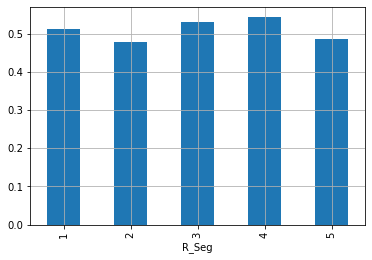

In [112]:
rfm_response.groupby('R_Seg')['response'].mean().plot.bar(grid=True)

Text(0, 0.5, 'Proportion of Responders')

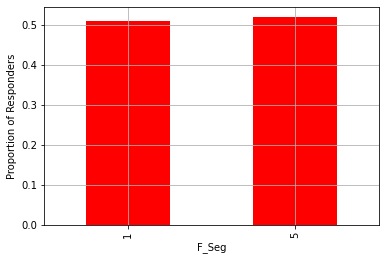

In [113]:
# frequency 和  reponse
ax = rfm_response.groupby('F_Seg')['response'].mean().plot.bar(grid=True ,color='red')
ax.set_ylabel('Proportion of Responders')


In [114]:
rfm_response.groupby('F_Seg')['response'].mean()

F_Seg
1    0.509281
5    0.519280
Name: response, dtype: float64

Text(0, 0.5, 'Proportion of Responders')

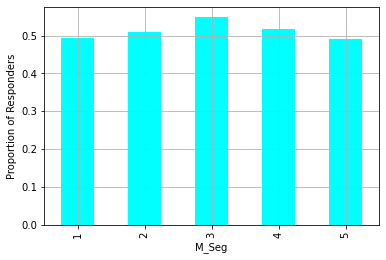

In [115]:
# monetary 和  reponse
ax = rfm_response.groupby('M_Seg')['response'].mean().plot.bar(grid=True ,color='cyan')
ax.set_ylabel('Proportion of Responders')

###  构建一个营销响应模型

In [119]:
#准备数据集X,y 
from sklearn.model_selection import train_test_split
X = rfm_response[['recency','frequency','monetary']]
y = rfm_response['response']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=1)
# 模型训练 
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train,y_train)

LogisticRegression()

In [120]:
print(lr.coef_)
print(lr.intercept_)

[[-7.11815076e-05  3.29406594e-07  1.10625322e-04]]
[1.04560541e-07]


In [121]:
# 分类评估报告
from sklearn.metrics import classification_report
# 对测试集X_test进行预测，得到y_pred
y_pred = lr.predict(X_test)
# 分类评估报告classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.52      0.25      0.34       310
           1       0.52      0.77      0.62       324

    accuracy                           0.52       634
   macro avg       0.52      0.51      0.48       634
weighted avg       0.52      0.52      0.49       634

